## Lab 5: Understanding gradient descent for logistic regression

In this lab, we will investigate how the gradient descent works on the logistic regression case with 1 parameter


### A few imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import Output,interact
from IPython.display import display
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib.widgets import Slider, Button, TextBox
import matplotlib.colors as colors


### Help functions

In [2]:
def sigmoid_grid(t,coef_meshgrid):

    data = np.ones((t.shape[0],2))
    data[:,0] = t[:,0] # Ndata * 2
    result = - np.inner(coef_meshgrid,data) # size_mesh,ndata
    return 1/(1+np.exp(result))

In [3]:
def log_likelihood_grid(t,litho,coef_meshgrid):
    prob_litho1 = sigmoid_grid(t,coef_meshgrid)
    sum_prob = np.inner(np.log10(prob_litho1),litho) + np.inner(np.log10(1-prob_litho1),1-litho) # size_mesh,
    n = litho.shape[0]
    return -sum_prob/(n)


In [4]:
def der_log_likelihood(t,litho,coef):
    data = np.ones((t.shape[0],2))
    data[:,0] = t[:,0] # Ndata * 2
    term = np.inner(sigmoid_grid(t,coef)-litho,data.T) # dim 1*2
    n = t.shape[0]
    return term / n

In [5]:
def update_parameters(t,litho,coef,learning_rate):
    coef = coef - learning_rate * der_log_likelihood(t,litho,coef)
    return coef

### Fetching data

In [ ]:
# Fetch data

datapath = 'https://raw.githubusercontent.com/scienxlab/datasets/refs/heads/main/rpc/rpc-4-lithologies.csv' # Put your own path here
df = pd.read_csv(datapath)

In [7]:
# The data consist in samples from the rock property catalogs, compiled in https://agilescientific.com/blog/2015/10/5/the-rock-property-catalog-again, 
# compiled about Cretaceous shales in North America. In this subset, we have 4 different types of rocks and 3 parameters 
# (Rho = bulk density; vp = P-wave velocity and vs = S-wave velocity)

df.Lithology.unique()

array(['sandstone', 'shale', 'limestone', 'dolomite'], dtype=object)

In [8]:
df.columns

Index(['RPC', 'Description', 'Lithology', 'Vp', 'Vs', 'Rho'], dtype='object')

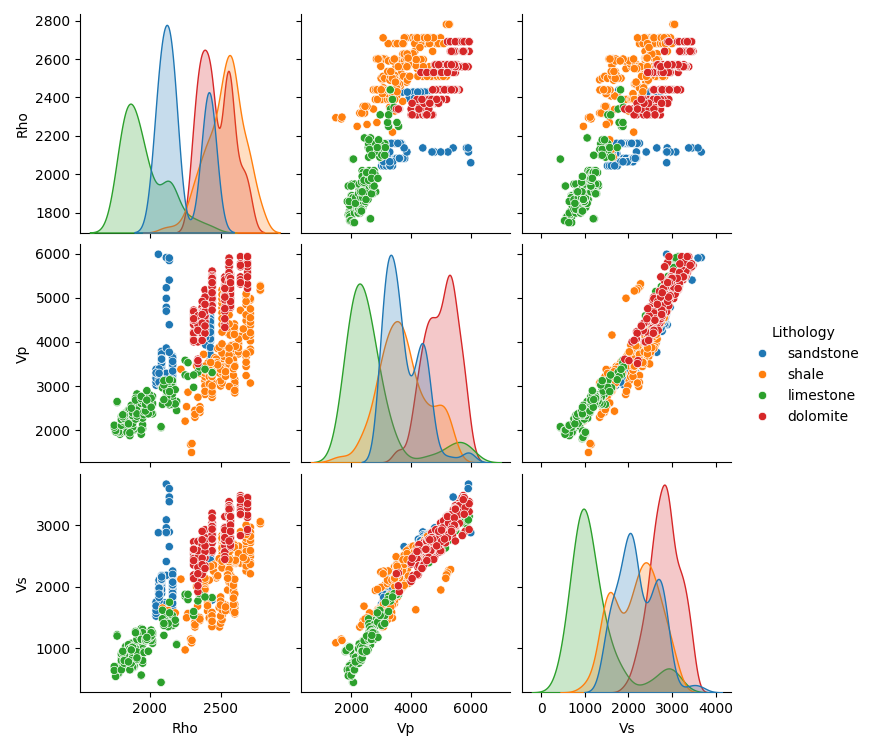

In [9]:
# Making a few plots to get to know the data:
# It looks like we could well discriminate data using a combination of 2 attributes. We'll start before that with one attribute

sns.pairplot(df,hue='Lithology',vars=['Rho','Vp','Vs'])

### Sigmoid with one variable

We start with one variable and try to understand the effect of the two parameters on the classification. 

Please feel free to update the feature selected (from Rho, Vp and Vs) in the cell below and of the 2 lithologies

In [10]:
### SELECT one attribute to work with and 2 lithologies

att_sel_1 = ['Rho']
litho_0 = 'limestone' 
litho_1 = 'dolomite'

In [11]:
### Extract data relevant for analysis 

work_df = df[att_sel_1 + ['Lithology']].copy()
work_df = work_df.query('Lithology ==@litho_0 | Lithology ==@litho_1')

# Then we encode the lithology to 0/1
work_df['Lithology']=work_df.Lithology.replace({litho_0:0,litho_1:1})
work_df['Rho']=work_df['Rho'].apply(lambda x:x/1000)

C:\Users\pniv\AppData\Local\Temp\ipykernel_30724\1658657594.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  work_df['Lithology']=work_df.Lithology.replace({litho_0:0,litho_1:1})


In [12]:
# So now here is our working data wiht a few stats

work_df.groupby('Lithology').describe()

Rho                                                    
           count      mean       std   min   25%   50%     75%   max
Lithology                                                           
0          152.0  1.961447  0.157772  1.75  1.83  1.91  2.0825  2.44
1          200.0  2.470650  0.112599  2.31  2.37  2.44  2.5600  2.69

In [13]:
work_df.dropna(axis=0,how='any',inplace=True)

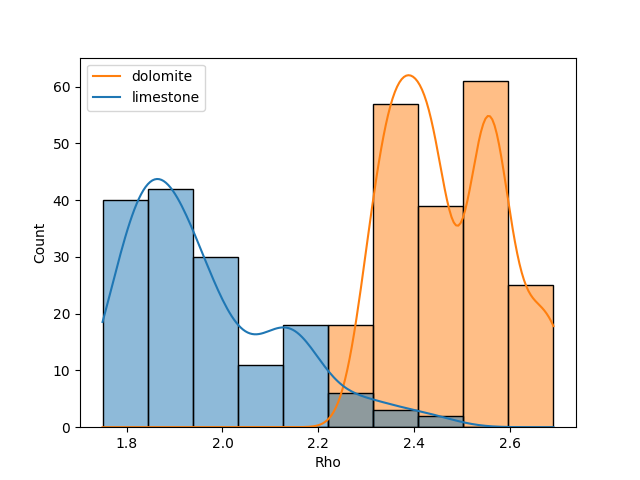

In [14]:
fig,ax = plt.subplots()
sns.histplot(work_df,x="Rho",hue='Lithology',kde=True)
ax.legend([litho_1,litho_0])


C:\Users\pniv\AppData\Local\Temp\ipykernel_30724\3603609205.py:3: RuntimeWarning: divide by zero encountered in log10
  sum_prob = np.inner(np.log10(prob_litho1),litho) + np.inner(np.log10(1-prob_litho1),1-litho) # size_mesh,


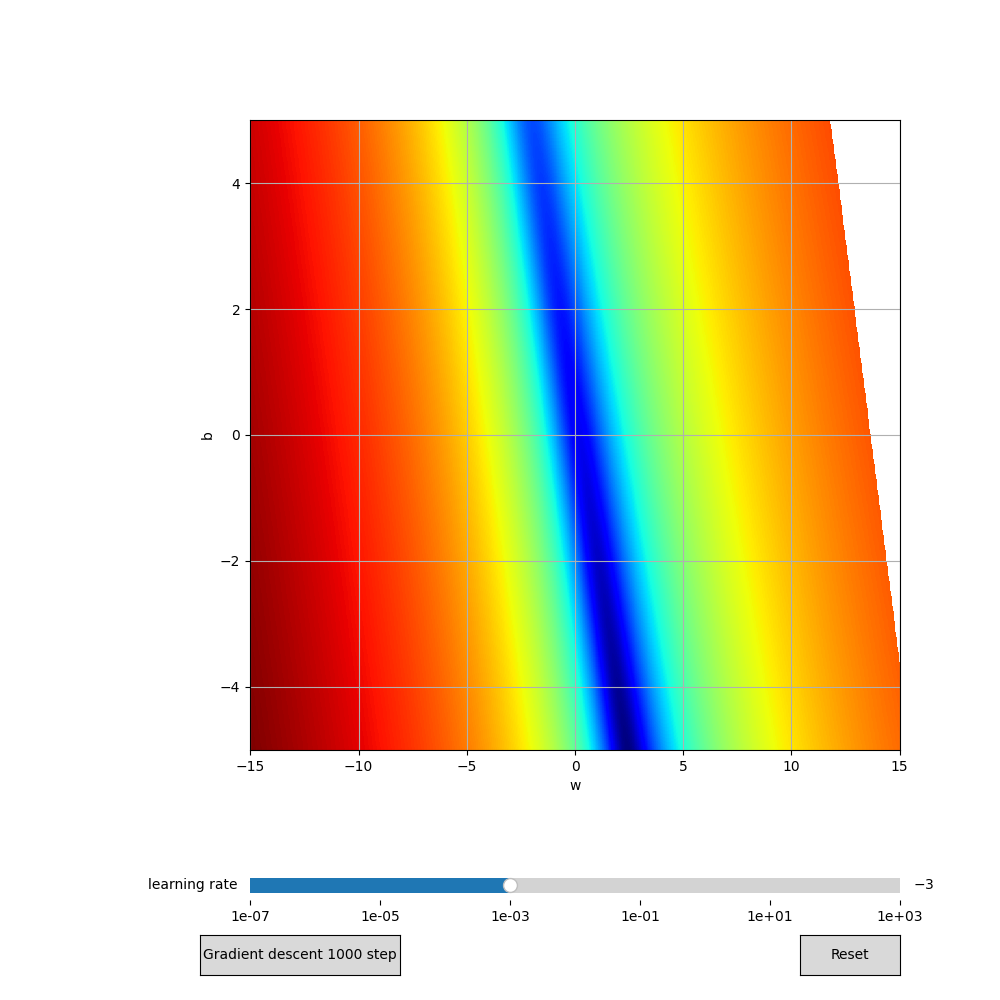

In [15]:
# The parametrized function to be plotted


xmin = -15
xmax = 15#10/ work_df[att_sel_1].std().values[0]
ymin = -5
ymax = 5

x = np.linspace(xmin, xmax, 1000)
y = np.linspace(ymin, ymax, 1000)
XY = np.meshgrid(x,y)
xy =np.vstack((XY[0].flatten(),XY[1].flatten())).T

# Define cost function paysage
image_cost= log_likelihood_grid(work_df[att_sel_1].values,work_df['Lithology'].values,xy)

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots(figsize=(10,10))
init_point=0
init_data = [0,0]
lr = 1e-3
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.pcolormesh(x,y,image_cost.reshape(1000,1000),cmap='jet',norm=colors.LogNorm(vmin=np.nanmin(image_cost),vmax=np.nanmax(image_cost)))
optim, = ax.plot([],[], 'k-',lw=2)

ax.grid()

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Define the click event handler
def onclick(event):
    global init_point
    if len(optim.get_xdata()) == 0:
        if event.inaxes is not None:
            optim.set_data([event.xdata],[event.ydata])
            init_point = 1

cid = fig.canvas.mpl_connect('button_press_event', onclick)



# Make a horizontal slider to control lr.
axlr = fig.add_axes([0.25, 0.1, 0.65, 0.03])

lr_values = 10. ** np.arange(-7,4,2)
slider_values = np.log10(lr_values)
slider_lr_log = Slider(
    ax=axlr,
    label='learning rate',
    valmin=slider_values[0], 
    valmax=slider_values[-1], 
    valinit=-3,
    valstep=slider_values
)
value_formatter = lambda x: "{:.0e}".format(x)
axlr.add_artist(axlr.xaxis)
axlr.set_xticks(slider_values)
axlr.set_xticklabels([value_formatter(x) for x in lr_values])

def update_slider(val):
    global init_point
    init_point = 0
    optim.set_data([],[])
    lr = 10 ** val
    val_str = value_formatter(lr)
    slider_lr_log.valtext.set_text(val_str)
    fig.canvas.draw_idle()



slider_lr_log.on_changed(update_slider)



# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
updateax = fig.add_axes([0.2, 0.025, 0.2, 0.04])
update_button = Button(updateax, 'Gradient descent 1000 step', hovercolor='0.975')


def update_gd(event):
    global init_point
    init_point = 1
    lr = 10. ** slider_lr_log.val
    xdata = optim.get_xdata()
    ydata = optim.get_ydata()
    for _ in range(1000):
        starting_coef = np.array([xdata[-1],ydata[-1]])
        coef = update_parameters(work_df[att_sel_1].values, work_df['Lithology'].values,starting_coef,lr)
        xdata.append(coef[0])
        ydata.append(coef[1])
        optim.set_data(xdata,ydata)
        plt.draw()

update_button.on_clicked(update_gd)


# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    global init_point
    optim.set_data([],[])
    init_point = 0

    
button.on_clicked(reset)

plt.show()

# Congratulations ! 
you understand now why logistic regression really works better on classification problems than linear regression. 